# Etude du régime libre d'un circuit RC.
On se propose d'étudier le régime libre d'un circuit RC. Le but de cette expérience est de valider le modèle d'ordre 1 du circuit puis de déterminer la capacité C du condensateur, connaissant la résistance R.

Le circuit réalisé est donné ci-dessous (*La LED est là uniquement pour indiquer que la carte Arduino réalise une mesure*).

![Montage d'étude d'un circuit RC](Circuit_RC.png)

La valeur de la résistance est $R = 100 k \Omega$

L'entrée A0 servira à mesurer le potentiel électrique (*par rapport à une référence GND*) sur une des bornes du condensateur (*l'autre borne étant à 0V - **GND** on obtient ainsi la tension $U_C$*).

La sortie 2 simule l'entrée du circuit qu'on peut mettre en état haut (*tension de 5V = charge du condensateur*) ou un état bas (*tension de 0V = régime libre*).

La carte Arduino est [programmée](circuit_rc_decharge/circuit_rc_decharge.ino) (ce programme n'est pas à comprendre) pour :
* charger le condensateur
* recevoir la durée d'acquisition de l'utilisateur
* démarrer le régime libre puis renvoyer un couple de mesure (temps, tension $U_C$) jusqu'à la fin de la durée d'acquisition.

Les résultats ont été enregistrés par un programme Python dans un fichier de données. On se propose d'utiliser ces données pour:
* tracer $U_C$ et valider le modèle attendu de décroissance exponentielle
* déterminer sur cet exemple le temps caractéristique puis la capacitance associée.

**Recherche préliminaire** Le condensateur utilisé est marqué. Le constructeur indique une capacitance $C = 0.1 \mu F$. On attend donc un temps caractéristique de l'ordre de $\tau = 10 ms$

*On commence par importer les modules utiles pour manipuler les données et tracer des graphiques*

In [1]:
%pylab
%matplotlib inline
from scipy.optimize import curve_fit

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Importation des données
On commence par importer les données. On va les enregistrer dans deux vecteurs :
* `temps` : données des temps de mesure
* `tensions` : données des tensions $U_C$ mesurées

`n_mesures` permet d'obtenir le nobmre de points de mesures.

In [2]:
filename = "circuit_rc_decharge.dat"
with open(filename, 'r') as file:
    datas = loadtxt(file, delimiter=",", skiprows=1)
    temps = datas[:, 0]
    n_mesures = temps.size
    tensions = datas[:, 1]

Il faut d'abord mettre en forme les données de mesure :
* `temps` correspond à des mesures en microsecondes de **l'intervalle de temps entre deux mesures**. On va donc sommer ces durées pour avoir les temps de mesure.
* `tensions`  ne correspond pas à la tension mesurée (entre 0 et 5V) mais au **codage binaire** issu de la conversion analogique-numérique (entre 0 et 1023). Il faut donc transformer la liste pour revenir aux valeurs de tension.

In [3]:
# Traitement de temps
temps2 = temps
for i in range(len(temps2)):
    if i > 0:
        temps2[i] = temps2[i-1] + temps[i]

# Traitement de tensions
B_MAX = 1023
U_MAX = 5
B_MIN = 0
U_MIN = 0
tensions2 = (tensions - B_MIN) / (B_MAX - B_MIN) * (U_MAX - U_MIN) + U_MIN

## Etude des données - Tracé de l'évolution temporelle de la tension.
On va tracer la tension puis valider graphiquement un modèle d'exponentielle décroissante.

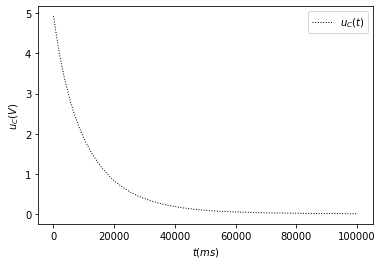

In [4]:
f = figure(1)  # On crée une figure
ax1 = f.add_subplot(1, 1, 1)  # Création des axes du graphiques
ax1.plot(temps2, tensions2, label=r"$u_C(t)$", linestyle=':', linewidth=1, color="black")  # Création de la courbe

ax1.set_ylabel(r"$u_C(V)$")  # Légende des axes
ax1.set_xlabel(r"$t(ms)$")  # Légende des axes
ax1.legend()  # Fait apparaître la légende à droite du graphique

On peut considérer que l'allure est cohérente avec un modèle d'ordre 1. 

## Modélisation de la courbe expérimentale.
On va réaliser un ajustement des données expérimentales avec le modèle attendu :
$$ U_C(t) = A \exp(-t / \tau)$$

### Détermination des paramètres A et $\tau$ d'ajustement
*On utilise pour cela la fonction `curve_fit` du module `scipy.optimize` importé au début. A noter la liste `p0` qui correspond à des valeurs initiales pour les paramètres $\tau$ et A. Si on peut il est préférable de les choisir proche des valeurs attendues.*

In [5]:
""" On commence par définir une fonction qui correspond au modèle choisi."""
def modele_exp(t, tau, A):
    y = A * np.exp(-t / tau)
    return y

"""On utilise la fonction curve_fit pour obtenir les paramètres d'ajustement tau et A (enregistrés dans params)"""
params, corel = curve_fit(modele_exp, temps2, tensions2, p0 = [10000., 5.])  # Cette fonction réalise l'ajustement et renvoie dans params les paramètres optimaux.

### Comparaison entre le modèle et les données expérimentales.
Il est fondamental de comparer le modèle et les données expérimentale. Cette comparaison est graphique.

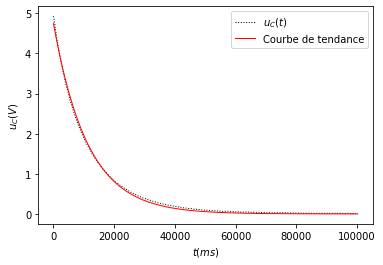

In [6]:
lntensions_fit = modele_exp(temps2, params[0], params[1]) # On applique les paramètres d'ajustment aux distance pour pouvoir tracer le modèle et les résultats.

f = figure(1)  # On crée une figure
ax1 = f.add_subplot(1, 1, 1)  # Création des axes du graphiques
ax1.plot(temps2, tensions2, label=r"$u_C(t)$", linestyle=':', linewidth=1, color="black")  # Création de la courbe
ax1.plot(temps2, lntensions_fit, label="Courbe de tendance", linestyle='-', linewidth=1, color="red")  # Création de la courbe

ax1.set_ylabel(r"$u_C(V)$")  # Légende des axes
ax1.set_xlabel(r"$t(ms)$")  # Légende des axes

ax1.legend()  # Fait apparaître la légende à droite du graphique

## Analyse du temps caractéristique. Valeur de C.
On va utiliser le premier paramètre renvoyé comme valeur de $\tau$. On peut ensuite en déduire $C = {\tau \over R}$.

In [7]:
print('tau = {:5.0f} micro s'.format(params[0]))
R = 1e5
C = params[0] / R  # On reste en microFarad
print('C = {:0.2f} micro F'.format(C))

tau = 11275 micro s
C = 0.11 micro F


On observe que la valeur de C est plus importante que la valeur annoncé par le constructeur. Malheureusement, on ne peut par la méthode utilisée ici estimer l'incertitude sur le temps caractéristique et donc sur C. 

Néanmoins cette étude a permis de valider le modèle d'ordre 1 grâce à l'allure des courbes. On va donc pouvoir automatiser la mesure de $\tau$ pour réaliser une [étude statistique](./circuit_rc_auto.ipynb) des valeurs de C et ainsi estimer plus précisément la capacitance.

### Pour aller plus loin - Importance des valeurs initiales de l'optimization
*Remarque : On pourra essayer de changer les valeurs initiales de A et $\tau$ dans la fonction d'optimisation (liste `p0`). Si on les prends trop loin (exemple $[1., 1.]$), il est possible que l'ajustement soit faux. C'est pourquoi le tracé graphique précédent est* ***fondamental***

On donne ci-dessous les résultats données en prenant `p0 = [0., 0.]`.

/home/ubuntu/miniconda3/envs/prepa/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/miniconda3/envs/prepa/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


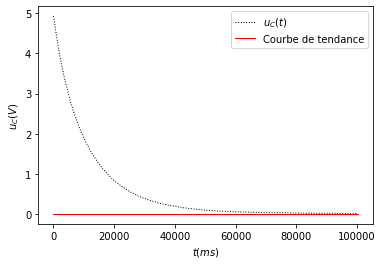

In [8]:
params, corel = curve_fit(modele_exp, temps2, tensions2, p0 = [0., 0.])  # Cette fonction réalise l'ajustement et renvoie dans params les paramètres optimaux.

lntensions_fit = modele_exp(temps2, params[0], params[1]) # On applique les paramètres d'ajustment aux distance pour pouvoir tracer le modèle et les résultats.

f = figure(1)  # On crée une figure
ax1 = f.add_subplot(1, 1, 1)  # Création des axes du graphiques
ax1.plot(temps2, tensions2, label=r"$u_C(t)$", linestyle=':', linewidth=1, color="black")  # Création de la courbe
ax1.plot(temps2, lntensions_fit, label="Courbe de tendance", linestyle='-', linewidth=1, color="red")  # Création de la courbe

ax1.set_ylabel(r"$u_C(V)$")  # Légende des axes
ax1.set_xlabel(r"$t(ms)$")  # Légende des axes

ax1.legend()  # Fait apparaître la légende à droite du graphique

Il est donc **fondamental** de vérifier graphiquement un modèle obtenu par optimisation.

### A effacer

0.10580164234983833


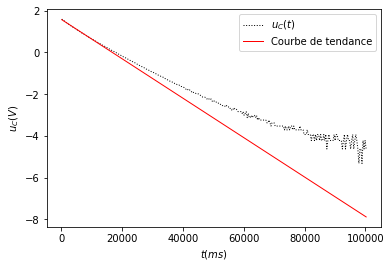

In [9]:
from scipy.stats import linregress

lntensions2 = log(tensions2)

N = 50
pente, o0, t1, t2, t3 = linregress(temps2[0:N], lntensions2[0:N])  # Cette fonction réalise l'ajustement et renvoie dans params les paramètres optimaux.

lntensions_fit2 = pente * temps2 + o0 # On applique les paramètres d'ajustment aux distance pour pouvoir tracer le modèle et les résultats.

f = figure(1)  # On crée une figure
ax1 = f.add_subplot(1, 1, 1)  # Création des axes du graphiques
ax1.plot(temps2, lntensions2, label=r"$u_C(t)$", linestyle=':', linewidth=1, color="black")  # Création de la courbe
ax1.plot(temps2, lntensions_fit2, label="Courbe de tendance", linestyle='-', linewidth=1, color="red")  # Création de la courbe

ax1.set_ylabel(r"$u_C(V)$")  # Légende des axes
ax1.set_xlabel(r"$t(ms)$")  # Légende des axes

ax1.legend()  # Fait apparaître la légende à droite du graphique

print(-1/pente / R)